In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from arch import arch_model

from var_es_toolbox.data import load_data
from var_es_toolbox.models import forecast_ugarch

In [2]:
project_dir = Path.cwd().parent
data_dir = project_dir / "data"
data_cleaned_name = "refinitiv_data_cleaned.csv"
date_format = "ISO8601"

data_cleaned = load_data(data_dir / data_cleaned_name, date_format=date_format)
futures_returns = data_cleaned.iloc[:, 1]

In [3]:
p = 1
q = 1
n = 5
mean = "constant"
vol = "garch"
dist = "normal"

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8508.740825988278
Iteration:      2,   Func. Count:     15,   Neg. LLF: 484848.72852888214
Iteration:      3,   Func. Count:     21,   Neg. LLF: 371.8384046794547
Iteration:      4,   Func. Count:     28,   Neg. LLF: 754.8404640480622
Iteration:      5,   Func. Count:     34,   Neg. LLF: 364.2377289517067
Iteration:      6,   Func. Count:     41,   Neg. LLF: 293.4272803933329
Iteration:      7,   Func. Count:     47,   Neg. LLF: 292.7314959387321
Iteration:      8,   Func. Count:     52,   Neg. LLF: 292.73131528700486
Iteration:      9,   Func. Count:     56,   Neg. LLF: 292.73131528722905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 292.73131528700486
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            DBc1_return   R-squared:            

[Text(0.5, 1.0, 'Distribution of Standardized Residuals')]

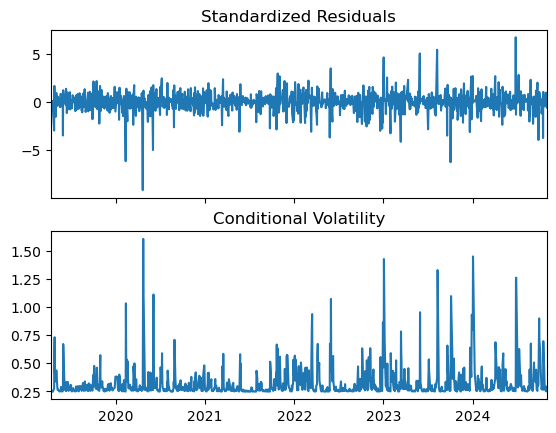

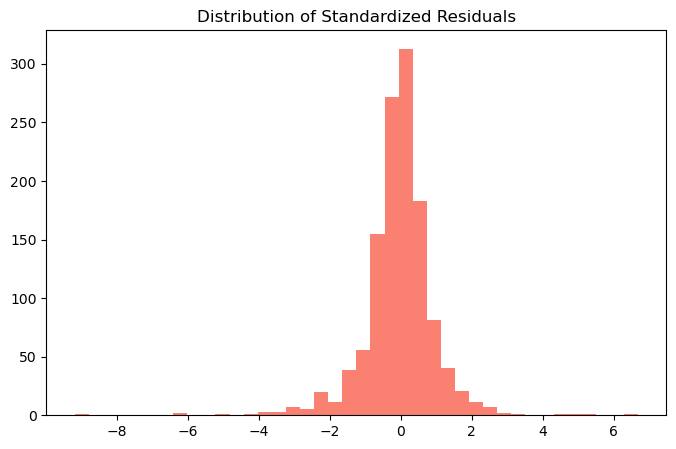

In [4]:
basic_gm = arch_model(futures_returns, p=p, q=q, mean=mean, vol=vol, dist=dist)

gm_result = basic_gm.fit()
print(gm_result.summary())
gm_result.plot()

# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon=n)

# Print the forecast variance
print(gm_forecast.variance[-1:])

# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

In [5]:
forecast_garch_result = forecast_ugarch(futures_returns, p=p, q=q, n=n, verbose=0, mean=mean, dist=dist)
print(forecast_garch_result.variance)

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2024-10-31  0.075562  0.096706  0.110363  0.119184  0.124881


In [6]:
from scripts.renv_utils import activate_renv

activate_renv()

from rpy2.robjects import pandas2ri, r, globalenv
%load_ext rpy2.ipython

- renv activated -- please restart the R session.


C:\Users\chris\Anaconda\envs\var-es-010\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [7]:
c = 0.05
p = 1
q = 1
m = 1000
n = 200
refit = 10

In [8]:
globalenv['df'] = pandas2ri.py2rpy(futures_returns.reset_index())
globalenv['df_all'] = pandas2ri.py2rpy(data_cleaned.reset_index())
globalenv['c'] = c
globalenv['p'] = p
globalenv['q'] = q
globalenv['m'] = m
globalenv['n'] = n
globalenv['refit'] = refit

models_dir = project_dir / "src" / "var_es_toolbox" / "models"
r_arch_models_path = models_dir / "r_arch_models.R"
r_hybrid_evt_models_path = models_dir / "r_hybrid_evt_models.R"
r_non_param_path = models_dir / "non_parametric_models.R"
r_gas_models_path = models_dir / "r_gas_models.R"
r_caviar_models_path = models_dir / "r_caviar_models.R"
globalenv['r_non_param_path'] = str(r_non_param_path)
globalenv['r_arch_models_path'] = str(r_arch_models_path)
globalenv['r_hybrid_evt_models_path'] = str(r_hybrid_evt_models_path)
globalenv['r_gas_models_path'] = str(r_gas_models_path)
globalenv['r_caviar_models_path'] = str(r_caviar_models_path)

In [17]:
%%R
library(rugarch)
library(xts)
library(psych)
library(ggplot2)             
library(parallel)

num_cores <- detectCores()

names(df)[names(df) == "DBc1_return"] <- "Return"
returns <- xts(tail(df$Return, n), order.by = tail(df$Date, n))

desc_stat <- psych::describe(df_all)
print(desc_stat)

ggplot(df, aes(x=Date, y=Return)) +
    geom_line(color="blue") +
    ggtitle("DBc1 Returns") +
    xlab("Date") +
    ylab("Return (%)")

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 's' not found


RInterpreterError: Failed to parse and evaluate line 'library(rugarch)\nlibrary(xts)\nlibrary(psych)\nlibrary(ggplot2)             \nlibrary(parallel)\ns\nnum_cores <- detectCores()\n\nnames(df)[names(df) == "DBc1_return"] <- "Return"\nreturns <- xts(tail(df$Return, n), order.by = tail(df$Date, n))\n\ndesc_stat <- psych::describe(df_all)\nprint(desc_stat)\n\nggplot(df, aes(x=Date, y=Return)) +\n    geom_line(color="blue") +\n    ggtitle("DBc1 Returns") +\n    xlab("Date") +\n    ylab("Return (%)")\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 's' not found"

           m.c.seq.row..seq.n...seq.col..drop...FALSE.
2023-11-24                                   0.4455924
2023-11-27                                   0.4455924
2023-11-28                                   0.4455924
2023-11-29                                   0.4455924
2023-11-30                                   0.4455924
2023-12-01                                   0.4455924
2023-12-04                                   0.4455924
2023-12-05                                   0.4455924
2023-12-06                                   0.4455924
2023-12-07                                   0.4455924
       ...                                            
2024-10-18                                   0.5217704
2024-10-21                                   0.5170500
2024-10-22                                   0.5170500
2024-10-23                                   0.5170500
2024-10-24                                   0.5170500
2024-10-25                                   0.5170500
2024-10-28


Calculations completed.



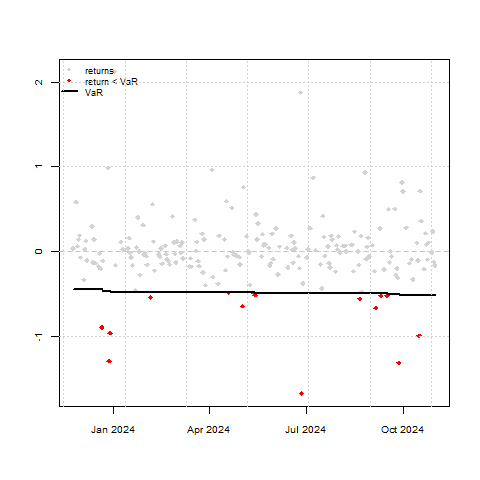

In [25]:
%%R
source(r_non_param_path)

var <- - forecast_u_HS_var(df, c, n, m)
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

In [ ]:
%%R
source(r_non_param_path)

var <- - forecast_u_FHS_GARCH_var(df, c, n, m, b = 100)
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

Exception ignored from cffi callback <function _callback at 0x0000021B7BF05760>:
Traceback (most recent call last):
  File "C:\Users\chris\Anaconda\envs\var-es-010\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 326, in _callback
    @ffi_proxy.callback(ffi_proxy._callback_def,
    
KeyboardInterrupt: 


In [ ]:
%%R
source(r_arch_models_path)

var <- - forecast_u_GARCH_var(df, c, n, m, 1, 1, 20, "gjrGARCH", "sstd")
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

In [ ]:
%%R
source(r_gas_models_path)

var <- - forecast_u_GAS_var(df, c, n, m, 20, "sstd")
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

           m.c.seq.row..seq.n...seq.col..drop...FALSE.
2023-11-24                                  -0.6518887
2023-11-27                                  -0.4818054
2023-11-28                                  -0.6703564
2023-11-29                                  -0.4938780
2023-11-30                                  -0.4392822
2023-12-01                                  -0.4358437
2023-12-04                                  -0.4070691
2023-12-05                                  -0.4943714
2023-12-06                                  -0.4225684
2023-12-07                                  -0.4125968
       ...                                            
2024-10-18                                  -1.0127618
2024-10-21                                  -0.7192453
2024-10-22                                  -0.5176310
2024-10-23                                  -0.4710981
2024-10-24                                  -0.3942547
2024-10-25                                  -0.3805053
2024-10-28

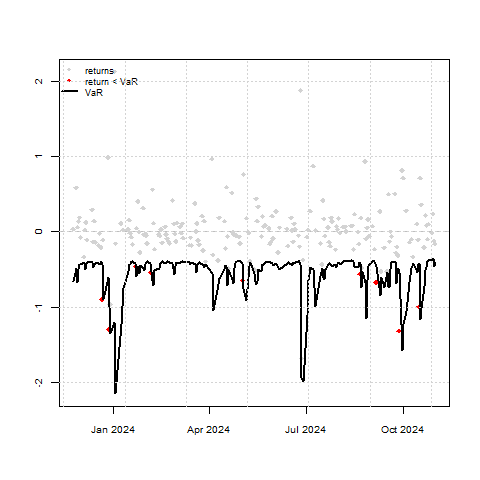

In [49]:
%%R
source(r_hybrid_evt_models_path)

var <- forecast_u_EVT_GARCH_var(df, c, n, m, t = 0.95)
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

In [ ]:
%%R
source(r_caviar_models_path)

var <- - forecast_u_CAViaR_var(df, c, n, m, r = 1, model_type = "adaptive", G = 10, itermax = 100)
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

In [ ]:
%%R
library(quantreg)

qreg_model <- rq(df_all$Return ~ 1, tau = c)
print(summary(qreg_model))

In [ ]:
%%R
library(rugarch)

print(VaRTest(c, returns, var))

In [ ]:
%%R
library("ggplot2")             

ggplot(df, aes(x=`Date`, y=`NPE EDEFB D1 - return`)) +
    geom_line(color="blue") +
    ggtitle("NPE EDEFB D1 Returns") +
    xlab("Date") +
    ylab("Return (%)")

In [ ]:
models_dir = project_dir / "src" / "var_es_toolbox" / "backtesting"
r_backtesting_path = models_dir / "r_backtesting.R"
r.source(str(r_backtesting_path))

backtest_er = r["backtest_er"]
backtest_er_result = backtest_er([0.1], [5], [4.5], [30], 1000)

globalenv['r_backtesting_path'] = str(r_backtesting_path)

In [ ]:
%%R

source(r_backtesting_path)
result <- backtest_er(df, p, q, n)
print(result)